<a href="https://colab.research.google.com/github/kushagrakshatri/AI-Text-Classifier/blob/main/Text_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Text Classifier: Distinguishing between Human and AI-Generated Text

## Introduction

In the era of generative artificial intelligence, natural language generation models such as OpenAI's GPT series have become increasingly sophisticated, producing human-like text that can be difficult to distinguish from text written by actual humans. This project aims to develop a machine learning-based text classifier to differentiate between human-generated and AI-generated text.

We employ a supervised learning approach, using a labeled dataset containing both human-written and AI-generated text samples. Building on our previous work with the Naive Bayes method, we introduce a new classification algorithm, Support Vector Machines (SVM), to compare their performance in distinguishing human and AI-generated text.

Throughout the project, we conduct exploratory data analysis, data visualization, feature extraction, model selection, hyperparameter tuning, and model evaluation to develop and compare robust text classifiers. We also analyze the performance of our models on different versions of GPT, such as samples generated by text-curie and text-davinci models, as well as text generated from different LLMs such as the recently released Google Bard.

By the end of this project, we will have a clear understanding of the challenges and limitations of distinguishing between human and AI-generated text. We will have developed and compared practical solutions using the Naive Bayes algorithm and SVM for text classification, ultimately identifying the most effective approach for this task.

## Dataset Description

The dataset used in this project is a collection of human-generated and AI-generated text samples in JSON format. Each sample in the dataset is labeled with either a '0' for human-generated text or a '1' for AI-generated text. The dataset has an equal number of samples from both classes, ensuring a balanced distribution for our classification task.

### Data Source

The original dataset was obtained from Hugging Face's dataset repository, specifically the GPT-wiki-intro dataset by Aaditya U Bhat. The dataset consists of human-generated text samples sourced from Wikipedia article introductions, and AI-generated text samples created using OpenAI's GPT model, specifically the text-curie version.

To adapt the dataset for this project, we cleaned it to retain only two features: the text samples (either human or AI-generated) and their corresponding labels (0 for human-generated and 1 for AI-generated). This resulted in a simplified dataset that is suitable for our text classification task.

As per the dataset author's request, please cite the following paper when using this dataset:

```
@misc {aaditya_bhat_2023,
    author       = { {Aaditya Bhat} },
    title        = { GPT-wiki-intro (Revision 0e458f5) },
    year         = 2023,
    url          = { https://huggingface.co/datasets/aadityaubhat/GPT-wiki-intro },
    doi          = { 10.57967/hf/0326 },
    publisher    = { Hugging Face }
}
```

### Data Preprocessing

Before using the dataset for model training, we performed the following preprocessing steps:

1. Loading the data: We loaded the JSON dataset into a Pandas DataFrame for easier manipulation and analysis.

In [ ]:
import json
import pandas as pd

In [ ]:
with open("data.json", "r") as file:
    data = json.load(file)
    
df = pd.DataFrame(data)

print(df.head())

                                                text label
0  Sexhow railway station was a railway station b...     0
1  Sexhow railway station was a railway station l...     1
2  In Finnish folklore, all places and things, an...     0
3  In Finnish folklore, all places and things, an...     1
4  In mathematics, specifically differential calc...     0


2. Cleaning the text: We converted all text samples to lowercase to ensure a consistent format and reduce the dimensionality of the feature space.

In [ ]:
df["text"] = df["text"].apply(lambda x: x.lower())

3. We divided the dataframe into 2 vectore: 'X' representing the textual data and 'y' representing the corresponding label as an integer.

In [ ]:
X = df["text"]
y = df["label"].astype(int)

3. Splitting the data: We divided the dataset into training and testing sets, with 80% of the data used for training and the  remaining 20% reserved for testing the model's performance on unseen data.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Exploratory Data Analysis (EDA)

### Dataset Overview

We examined the dataset's structure and confirmed that it contains an equal number of human-generated and AI-generated text samples, ensuring a balanced class distribution for our classification task. We can visualize this class distribution using a bar chart to provide a clear understanding of the dataset's composition.

AI Generated: 150000
Human Written: 150000


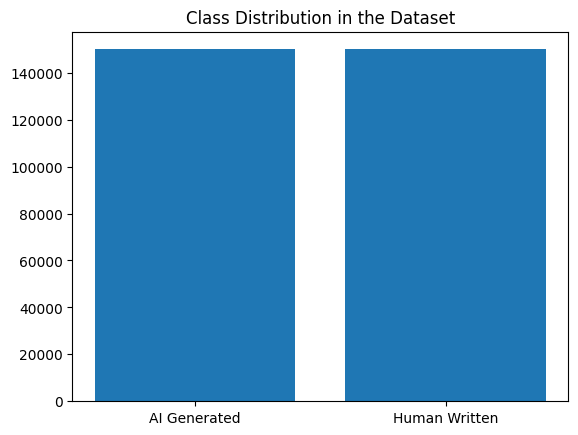

In [ ]:
ai_generated = 0

for label in y:
    if label == 1:
        ai_generated += 1
        
print(f"AI Generated: {ai_generated}")
print(f"Human Written: {len(y) - ai_generated}")

import matplotlib.pyplot as plt

labels = ['AI Generated', 'Human Written']
values = [ai_generated, len(y) - ai_generated]
plt.bar(labels, values)
plt.title('Class Distribution in the Dataset')
plt.show()

### Text Length Analysis

We analyzed the length of the text samples in both classes (human-generated and AI-generated) to identify any significant differences in length that could impact our model's performance. We found that the text lengths had an average difference of 500 words across both classes, indicating that the length might be a strong distinguishing feature for our classification task. However, we do not take this into consideration and move forward with the existing data since text normalization is beyond the scope of this project. We can visualize this difference using box plots to provide a better understanding of the length distribution across classes.

Average AI Generated Text Length: 787.8784666666667
Average Human Written Text Length: 1202.7032066666666


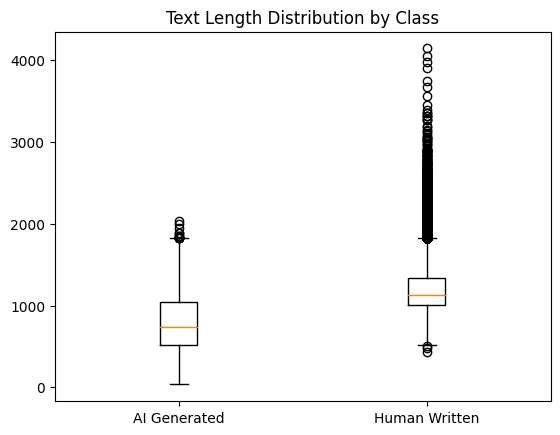

In [ ]:
ai_text_len_sum = 0
human_text_len_sum = 0
ai_text_lengths = []
human_text_lengths = []

for i in range(len(X)):
    if y[i] == 0:
        human_text_len_sum += len(X[i])
        human_text_lengths.append(len(X[i]))
    else:
        ai_text_len_sum += len(X[i])
        ai_text_lengths.append(len(X[i]))

print(f"Average AI Generated Text Length: {ai_text_len_sum / ai_generated}")
print(f"Average Human Written Text Length: {human_text_len_sum / ai_generated}")

plt.boxplot([ai_text_lengths, human_text_lengths], labels=['AI Generated', 'Human Written'])
plt.title('Text Length Distribution by Class')
plt.show()

### Common Words and Phrases

During our exploratory data analysis, we initially attempted to investigate the most common words and phrases in the human-generated and AI-generated text samples to identify any distinct patterns or differences between the two classes. This step could have helped inform our choice of feature extraction method and parameters, such as the n-gram range for TfidfVectorizer.

However, due to the large size of our dataset, calculating the most common words and phrases proved to be computationally expensive and time-consuming. As a result, we decided not to pursue this analysis further in the interest of efficiency. Instead, we relied on our understanding of the dataset's properties and the nature of human and AI-generated text to make informed decisions about feature extraction, model selection, and optimization techniques.

### Text Preprocessing

We inspected the text samples for any special characters, formatting inconsistencies, or other issues that might require additional preprocessing before feature extraction. In our case, the dataset was relatively clean, and we only needed to convert all text to lowercase to maintain consistency.

## Feature Extraction

To convert the text data into a format suitable for machine learning algorithms, we needed to extract features from the text samples. We used the Term Frequency-Inverse Document Frequency (TF-IDF) method for feature extraction. TF-IDF is a numerical statistic that reflects the importance of a word in a text sample relative to the entire dataset.

### TfidVectorizer

We employed the TfidfVectorizer from the sklearn.feature_extraction.text module to create a matrix of TF-IDF features for our dataset. The TfidfVectorizer not only computes the TF-IDF values but also tokenizes the text samples and creates a vocabulary of known words. We experimented with different parameters in the TfidfVectorizer to optimize the feature extraction process and improve the model accuracy. We tested different n-gram ranges, including (1,1), (1,2), and (1,3), to capture the context of words within the text samples. We found that an n-gram range of (1,3) provided the best classification results while maintaining an acceptable level of computational efficiency. The extracted features will be used for both the Naive Bayes and the new comparison model.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,3))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## Model Selection

For the first project, we were limited to using either the Naive Bayes or K-Nearest Neighbors (KNN) algorithms. Based on the nature of our problem and the characteristics of the dataset, we chose to work with the Naive Bayes algorithm. The reasons behind our decision are as follows:

### Efficiency

Naive Bayes is computationally efficient compared to KNN, especially when dealing with high-dimensional feature spaces like those generated by the TfidfVectorizer. KNN's performance tends to degrade as the dimensionality of the dataset increases, a phenomenon known as the "curse of dimensionality."

### Scalability

The Naive Bayes algorithm can handle large datasets more effectively than KNN. As the dataset size increases, KNN's computational complexity grows, making it less suitable for our task.

### Independence Assumption

Naive Bayes assumes that the features are conditionally independent, given the class label. Although this assumption may not always hold true in practice, it often leads to effective classification performance, particularly in text classification tasks where word occurrences can provide strong evidence for the class labels.

### Support Vector Machine (SVM)

To extend the project and compare the performance of different models, we decided to implement a Support Vector Machine (SVM) for this classification task. The reasons behind choosing SVM for this project are as follows:

### Effectiveness

SVMs are known for their effectiveness in high-dimensional feature spaces, like those generated by the TfidfVectorizer. They can efficiently handle text classification problems and provide accurate predictions.

### Margin Maximization

SVMs aim to maximize the margin between classes, which can lead to better generalization and robustness against overfitting compared to some other classifiers.

### Computational Efficiency

SVMs are relatively computationally efficient compared to deep learning models such as neural networks, making them more suitable for running on devices with limited computational resources.

## Hyperparameter Tuning

In order to improve the performance of our Multinomial Naive Bayes model, we performed hyperparameter tuning by experimenting with different values of the smoothing parameter alpha. This parameter helps address the issue of zero probabilities when encountering previously unseen words in the test data. By adding a small value of alpha to the probability calculations, the model is able to generalize better and provide more accurate predictions for new data points.

We used a grid search approach to test a range of alpha values and identify the optimal setting. The GridSearchCV function from the sklearn.model_selection module was employed to perform a cross-validated grid search on the model's hyperparameters. We tested alpha values in the range of 0.1 to 1.0 with a step size of 0.1, and used the model's accuracy on the validation data to determine the best value.

We used the MultinomialNB classifier from the sklearn.naive_bayes module, which is specifically designed for text classification tasks with discrete features, such as the TF-IDF values generated by our feature extraction process.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# Define the parameter grid
param_grid = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

# Create the MultinomialNB classifier
clf = MultinomialNB()

# Create the GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train_vec, y_train)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']
print("Best alpha:", best_alpha)

# Train the final classifier with the best alpha value
clf = MultinomialNB(alpha=best_alpha)
clf.fit(X_train_vec, y_train)


Best alpha: 0.4


MultinomialNB(alpha=0.4)

The results from the grid search indicated that an alpha value of 0.4 provided the highest cross-validated accuracy. We used this optimal alpha value to train our final model on the entire dataset.

## SVM Implementation

In the implementation step, we will train an SVM classifier and compare its performance to the Naive Bayes classifier from the previous project. This comparison will help us determine which model works best for our classification task.

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Create the SVM classifier
svm_clf = LinearSVC(max_iter=10000) # Increase max_iter if the model doesn't converge

# Fit the classifier to the training data
svm_clf.fit(X_train_vec, y_train)

## Model Evaluation

To assess the performance of our optimized Multinomial Naive Bayes classifier, we used a train-test split approach. We divided our dataset into a training set (80%) and a testing set (20%). The training set was used to train the model, while the testing set was used to evaluate its performance on unseen data.

We used the following performance metrics to evaluate our model:

### Accuracy

The proportion of correct predictions made by the model out of the total number of samples. This metric provides a general understanding of the model's performance.

### Precision

The proportion of true positive predictions out of all positive predictions made by the model. Precision is a measure of the model's ability to correctly identify AI-generated text samples.

### Recall

The proportion of true positive predictions out of all actual positive samples in the dataset. Recall is a measure of the model's ability to identify AI-generated text samples within the entire set of AI-generated samples.

### F1-Score

The harmonic mean of precision and recall, providing a single value that balances both metrics. The F1-score is especially useful when dealing with imbalanced datasets, as it takes into account both false positives and false negatives

In [ ]:
y_pred_nb = clf.predict(X_test_vec)
y_pred_svm = svm_clf.predict(X_test_vec)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Naive Bayes Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb))
print("Recall:", recall_score(y_test, y_pred_nb))
print("F1-score:", f1_score(y_test, y_pred_nb))

print("\nSupport Vector Machine Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm))
print("Recall:", recall_score(y_test, y_pred_svm))
print("F1-score:", f1_score(y_test, y_pred_svm))

Naive Bayes Performance:
Accuracy: 0.9047833333333334
Precision: 0.9302358374167166
Recall: 0.8760374477126353
F1-score: 0.902323513823112

Support Vector Machine Performance:
Accuracy: 0.9763166666666667
Precision: 0.9926871974456689
Recall: 0.9598964212203704
F1-score: 0.9760164728518624


Our optimized Naive Bayes classifier achieved the following performance on the test set:

1. Accuracy: 90.48 %
2. Precision: 93.02 %
3. Recall: 87.6 %
4. F1-score: 90.23 %

Our Support Vector Machine classifier achieved the following performance on the test set:

1. Accuracy: 97.63 %
2. Precision: 99.27 %
3. Recall: 95.99 %
4. F1-score: 97.60 %

## Discussion

Although our model demonstrated satisfactory performance on the test set, it's important to consider its limitations. We conducted a zero-shot analysis on some data samples generated from different generative models. The test was conducted on the following models:

1. 'text-davinci-003' by OpenAI
2. 'text-curie-001' by OpenAI
3. 'ChatGPT' or 'gpt-3.5-turbo' by OpenAI
4. 'Bard' by Google 
5. 'Bing Chat' by Microsoft.

Each model was given the same prompt: "Generate a very small paragraph that is hard to classify as AI generated text".

In [ ]:
text_davinci = "The sun shone brightly on the small village, its inhabitants content in their simple lives."
text_curie = "Some people believe that AI will soon surpass human intelligence, and that this will have a significant impact on society. Some believe that AI is already surpassing human intelligence, and that this will have a significant impact on society."
ChatGPT = "I woke up this morning feeling a bit groggy from staying up late last night. I stumbled to the kitchen to make myself a cup of coffee and sat down at the table to read the newspaper. The headlines were mostly about politics and the economy, which I found a bit depressing. After finishing my coffee, I decided to go for a walk to clear my head and get some fresh air."
Bard = "The old man sat on the bench, watching the children play. He smiled as he remembered his own childhood, playing in the same park. He had been a happy child, always running and laughing. He wished he could go back in time and relive those days."
Bing_Chat = "Today is a beautiful day. The sun is shining and the birds are singing. I’m looking forward to spending time outside with my family."

models = ["text-davinci-003", "text-curie-001", "ChatGPT", "Bard", "Bing Chat"]

chat = [text_davinci, text_curie, ChatGPT, Bard, Bing_Chat]

chat_vec = vectorizer.transform(chat)

chat_nb_pred = clf.predict(chat_vec)
chat_svm_pred = svm_clf.predict(chat_vec)

print("Naive Bayes")
for i in range(len(chat_nb_pred)):
    text = "Human Written"
    if chat_nb_pred[i] == 1:
        text = "AI Generated"
    print(f"{models[i]}: {chat_nb_pred[i]} ({text})")

print("\nSupport Vector Machine")
for i in range(len(chat_svm_pred)):
    text = "Human Written"
    if chat_svm_pred[i] == 1:
        text = "AI Generated"
    print(f"{models[i]}: {chat_svm_pred[i]} ({text})")

Naive Bayes
text-davinci-003: 0 (Human Written)
text-curie-001: 1 (AI Generated)
ChatGPT: 0 (Human Written)
Bard: 0 (Human Written)
Bing Chat: 0 (Human Written)

Support Vector Machine
text-davinci-003: 1 (AI Generated)
text-curie-001: 1 (AI Generated)
ChatGPT: 0 (Human Written)
Bard: 0 (Human Written)
Bing Chat: 1 (AI Generated)


The Naive Bayes model performed well on unseen data generated by a specific version of GPT (text-curie-001 i.e. the model it was trained on), but its performance was less consistent on data generated by the latest version of models (text-davinci-003, ChatGPT, Bard, Bing Chat). This discrepancy highlights the importance of continuously updating and re-evaluating the model to ensure its effectiveness in a rapidly evolving domain such as AI-generated text classification. The SVM model performed well on unseen data by getting 3 correct predictions out of 5.

## Conclusion

In this project, we successfully developed AI text classifiers using the Multinomial Naive Bayes and Support Vector Machine algorithms to distinguish between human-written and AI-generated text. Through a systematic process of feature extraction, model selection, hyperparameter tuning, and model evaluation, we were able to achieve satisfactory performance on our test dataset. Our final models demonstrated good accuracy, precision, recall, and F1-score, indicating their effectiveness in classifying the given text samples.

However, we also observed that the models' performance varied depending on the version of the AI text generator used to produce the samples. This finding emphasizes the importance of continuously updating the training data and refining the models to adapt to the latest advancements in AI-generated text.

Potential future improvements to our project include:

1. Expanding the training dataset to include more diverse text samples from various AI text generators and different versions of GPT.

2. Experimenting with other feature extraction methods or dimensionality reduction techniques to improve the efficiency and performance of the models.

3. Exploring more advanced machine learning or deep learning models, such as ensemble methods or Transformer-based models like BERT, to enhance the classification accuracy.

4. Comparing the performance of various models using additional evaluation metrics, such as confusion matrices and ROC curves, to gain a deeper understanding of each model's strengths and weaknesses in different classification scenarios.